# Model ResNet50V2

## Work in progress...

In [20]:
# Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import ResNet50V2

## Some useful parameters for the model

In [2]:
# Parameters
img_height = 100
img_width = 100
batch_size = 32
num_classes = 131
epochs = 15

## Preparing Data

In [3]:
# Loading our data from the directories and making a validation set from training data
train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    'C:/Users/Palmg/Desktop/fruits-360/Training',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'C:/Users/Palmg/Desktop/fruits-360/Training',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    'C:/Users/Palmg/Desktop/fruits-360/Test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)



Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


## Defining ResNet50V2 model

In [4]:
# The pre-trained model
base_resnet50V2 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_resnet50V2.trainable = False

# Build the model
model = Sequential()

model.add(base_resnet50V2)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 131)               67203     
                                                                 
Total params: 40,409,731
Trainable params: 16,844,931
Non-trainable params: 23,564,800
_________________________________________________________________


## Training

In [5]:
"""
Callback function to stop the model if the validation accuracy hasn't improved by 1 percentage in the last 5 epochs
and then choosing the best model.
"""
callback = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5,
    min_delta=0.01,
    restore_best_weights=True
)

# Training
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1,
    callbacks=[callback]
)

print('Test accuracy:', test_acc)

Epoch 1/15
1694/1694 [==============================] - 669s 394ms/step - loss: 1.6747 - accuracy: 0.6329 - val_loss: 0.4242 - val_accuracy: 0.9037
Epoch 2/15
1694/1694 [==============================] - 553s 326ms/step - loss: 0.9034 - accuracy: 0.7868 - val_loss: 0.4777 - val_accuracy: 0.9172
Epoch 3/15
1694/1694 [==============================] - 572s 337ms/step - loss: 0.8505 - accuracy: 0.8148 - val_loss: 0.3824 - val_accuracy: 0.9345
Epoch 4/15
1694/1694 [==============================] - 580s 342ms/step - loss: 0.7395 - accuracy: 0.8398 - val_loss: 0.5153 - val_accuracy: 0.9322
Epoch 5/15
1694/1694 [==============================] - 580s 343ms/step - loss: 0.7144 - accuracy: 0.8543 - val_loss: 0.3698 - val_accuracy: 0.9407
Epoch 6/15
1694/1694 [==============================] - 595s 351ms/step - loss: 0.7038 - accuracy: 0.8639 - val_loss: 0.4687 - val_accuracy: 0.9477
Epoch 7/15
1694/1694 [==============================] - 671s 396ms/step - loss: 0.6832 - accuracy: 0.8716 - val_

## Plotting the training progress

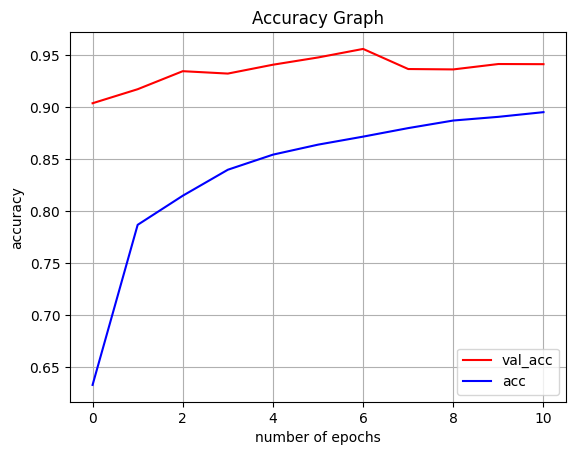

In [30]:
plt.plot(history.history["val_accuracy"],color="r",label="val_acc")
plt.plot(history.history["accuracy"], color="b", label="acc" )
plt.title("Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

## Saving Model

In [7]:
model.save("/Users/Palmg/Desktop/machineLearningModels/resNet50V2_BSc_model.h5")

## Loading Model

In [21]:
model = load_model("/Users/Palmg/Desktop/machineLearningModels/resNet50V2_BSc_model.h5")

## Predictions

1/1 [==============================] - 0s 245ms/step


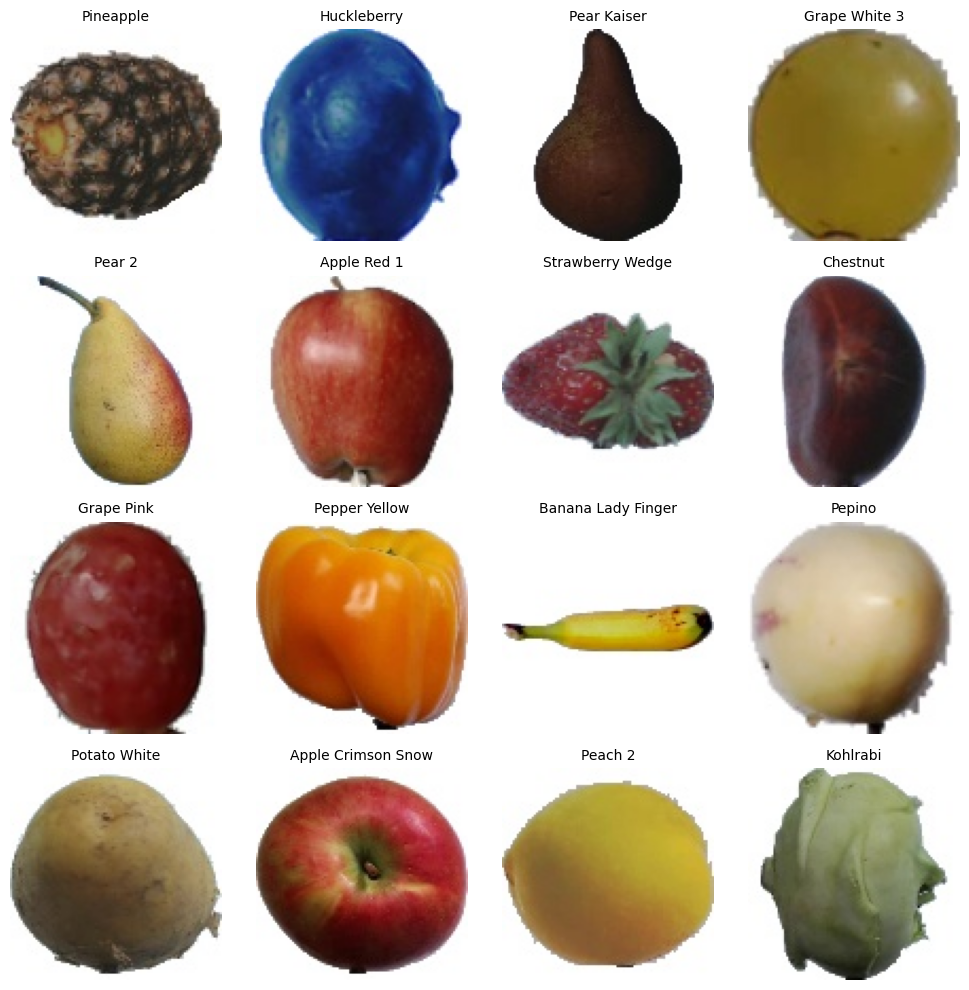

In [27]:
# Get predictions for a batch of test images
test_images, test_labels = next(test_generator)
pred_probs = model.predict(test_images)
pred_classes = np.argmax(pred_probs, axis=1)

# Define a list of class labels
class_labels = list(test_generator.class_indices.keys())

# Create a 4x4 subplot of images and their predicted classes
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i])
    ax.axis('off')
    ax.set_title(class_labels[pred_classes[i]], fontsize=10)
plt.tight_layout()
plt.show()